_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Lalitha Sivakumar, Madhavi Sen, Kübra Ozdemir

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-24 11:36:25CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

sklearn: 1.3.0

matplotlib: 3.7.2
numpy     : 1.24.3
pandas    : 2.0.3

Watermark: 2.4.3



In [2]:
!pip install "openTSNE"

In [3]:
plt.style.use(
    "/Users/kubraozdemir/Downloads/Neural Data Science/CL1/matplotlib_style.txt"
)

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [4]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv(
    "/Users/kubraozdemir/Downloads/Neural Data Science/CL7/nds_cl_7/harris-data/expression.tsv.gz",
    sep="\t",
)
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv(
    "/Users/kubraozdemir/Downloads/Neural Data Science/CL7/nds_cl_7/harris-data/analysis_results.tsv",
    sep="\t",
)
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv(
    "/Users/kubraozdemir/Downloads/Neural Data Science/CL7/nds_cl_7/harris-data/colormap.txt",
    sep="\s+",
    header=None,
)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [5]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
avg_expression = counts.mean(axis=0)

# Compute the fraction of zeros for each gene
fraction_zeros = (counts == 0).mean(axis=0)

In [6]:
# Compute the Poisson prediction
poisson_prediction = np.exp(-avg_expression)

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)

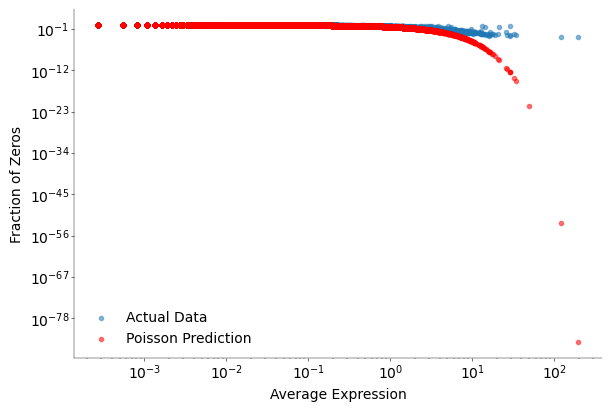

In [7]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(avg_expression, fraction_zeros, alpha=0.5, label="Actual Data")
ax.scatter(
    avg_expression,
    poisson_prediction,
    alpha=0.5,
    label="Poisson Prediction",
    color="red",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Average Expression")
ax.set_ylabel("Fraction of Zeros")
ax.legend()
plt.show()

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [8]:
# Compute the variance of the expression counts of each gene
var_expression = counts.var(axis=0)

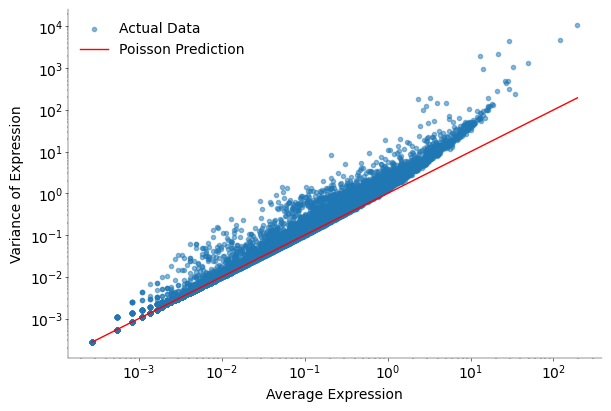

In [9]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------
# Scatter plot of mean vs variance
ax.scatter(avg_expression, var_expression, alpha=0.5, label="Actual Data")

# Plot the Poisson prediction as a line (mean = variance)
poisson_line = np.linspace(min(avg_expression), max(avg_expression), 100)
ax.plot(poisson_line, poisson_line, color="red", label="Poisson Prediction")

# Set log scale for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Set labels and legend
ax.set_xlabel("Average Expression")
ax.set_ylabel("Variance of Expression")
ax.legend()

plt.show()

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [10]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.

fano = var_expression / avg_expression

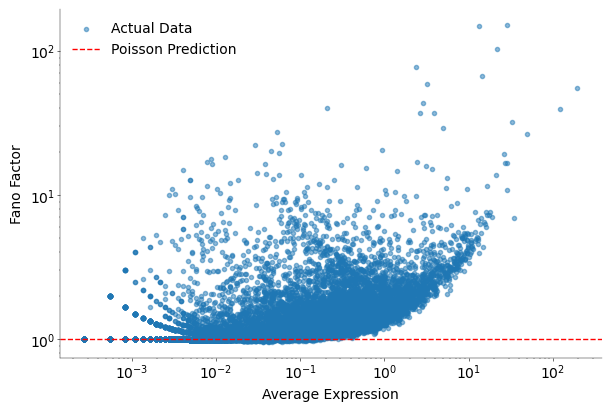

In [11]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Scatter plot of mean vs Fano factor
ax.scatter(avg_expression, fano, alpha=0.5, label="Actual Data")

# Plot the Poisson prediction as a horizontal line at Fano factor = 1
ax.axhline(1, color="red", linestyle="--", label="Poisson Prediction")

# Set log scale for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Set labels and legend
ax.set_xlabel("Average Expression")
ax.set_ylabel("Fano Factor")
ax.legend()

plt.show()

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

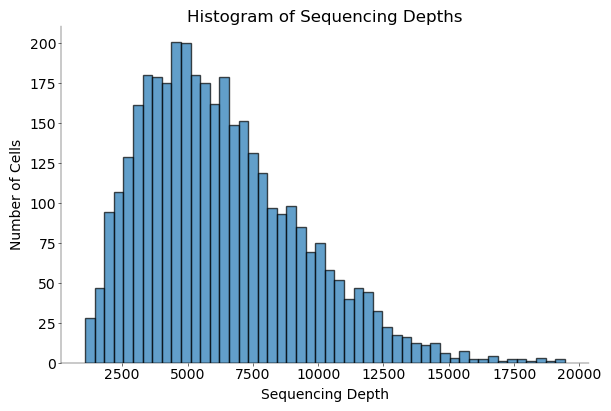

In [12]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------
# Calculate the sequencing depth for each cell
sequencing_depths = counts.sum(axis=1)
# Plot histogram
ax.hist(sequencing_depths, bins=50, edgecolor="black", alpha=0.7)

# Set labels
ax.set_xlabel("Sequencing Depth")
ax.set_ylabel("Number of Cells")
ax.set_title("Histogram of Sequencing Depths")

plt.show()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [13]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------
median_depth = np.median(sequencing_depths)
normalized_counts = (counts.T / sequencing_depths).T * median_depth

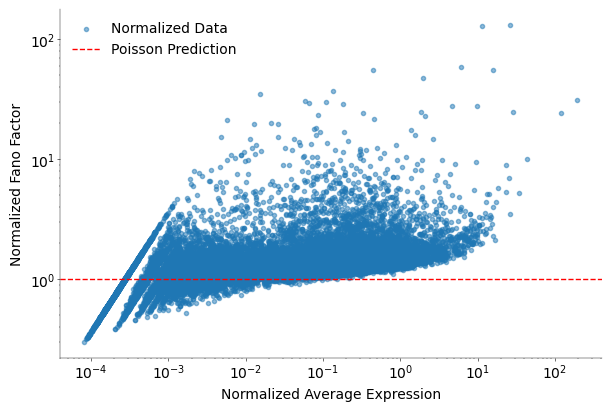

In [14]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
# Compute the mean and variance of the normalized counts for each gene
normalized_mean_expression = normalized_counts.mean(axis=0)
normalized_var_expression = normalized_counts.var(axis=0)

# Compute the Fano factor for each gene after normalization
normalized_fano = normalized_var_expression / normalized_mean_expression

# Plot the normalized mean expression vs. the normalized Fano factor
ax.scatter(
    normalized_mean_expression, normalized_fano, alpha=0.5, label="Normalized Data"
)
ax.axhline(1, color="red", linestyle="--", label="Poisson Prediction")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Normalized Average Expression")
ax.set_ylabel("Normalized Fano Factor")
ax.legend()
plt.show()

In [15]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array

top_genes_indices = np.argsort(normalized_fano)[-10:][
    ::-1
]  # Indices of the top 10 genes
top_genes = genes[top_genes_indices]
top_fano_factors = normalized_fano[top_genes_indices]

print("Top 10 genes with the highest normalized Fano factors:")
for gene, fano in zip(top_genes, top_fano_factors):
    print(f"{gene}: {fano}")

Top 10 genes with the highest normalized Fano factors:
Sst: 131.14152763839502
Npy: 128.39902525416767
Vip: 59.11491487972823
Cck: 55.65105498639613
Cpne2: 55.22031715653636
Pcp4: 47.65007481295161
Ptpn23: 37.246246826659586
Pdzd9: 35.05542057702027
Malat1: 31.42260972595051
Armc2: 30.58952939206677


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [16]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
# Select all genes with the normalized Fano factor above 3 and remove the rest

# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
median_depth = np.median(sequencing_depths)
normalized_counts = (counts.T / sequencing_depths).T * median_depth

# Compute the Fano factor for each gene after normalization
normalized_mean_expression = normalized_counts.mean(axis=0)
normalized_var_expression = normalized_counts.var(axis=0)
normalized_fano = normalized_var_expression / normalized_mean_expression

# Select genes with normalized Fano factor above 3
selected_genes = normalized_fano > 3
filtered_counts = normalized_counts[:, selected_genes]

In [17]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA

# perform PCA
pca = PCA(n_components=2)
pca_normal = pca.fit_transform(filtered_counts)

# Perform PCA after log2 transformation
log_transformed_counts = np.log2(filtered_counts + 1)
pca_log = pca.fit_transform(log_transformed_counts)

# Perform PCA after square root transformation
sqrt_transformed_counts = np.sqrt(filtered_counts)
pca_sqrt = pca.fit_transform(sqrt_transformed_counts)

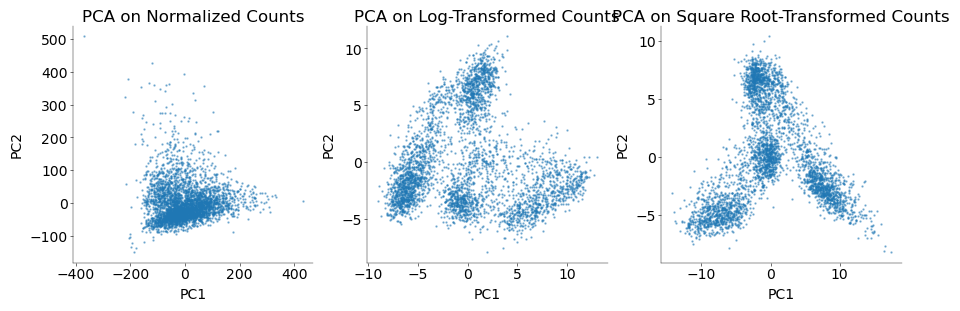

In [18]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
# Plot the first two principal components for each dataset

# PCA on normalized counts
axs[0].scatter(pca_normal[:, 0], pca_normal[:, 1], alpha=0.5, s=2)
axs[0].set_title("PCA on Normalized Counts")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

# PCA on log-transformed counts
axs[1].scatter(pca_log[:, 0], pca_log[:, 1], alpha=0.5, s=2)
axs[1].set_title("PCA on Log-Transformed Counts")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

# PCA on square root-transformed counts
axs[2].scatter(pca_sqrt[:, 0], pca_sqrt[:, 1], alpha=0.5, s=2)
axs[2].set_title("PCA on Square Root-Transformed Counts")
axs[2].set_xlabel("PC1")
axs[2].set_ylabel("PC2")

plt.show()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [19]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs

# Use default settings of openTSNE
# You can also use sklearn if you want

from sklearn.manifold import TSNE

# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
median_depth = np.median(sequencing_depths)
normalized_counts = (counts.T / sequencing_depths).T * median_depth

# Compute the Fano factor for each gene after normalization
normalized_mean_expression = normalized_counts.mean(axis=0)
normalized_var_expression = normalized_counts.var(axis=0)
normalized_fano = normalized_var_expression / normalized_mean_expression

# Select genes with normalized Fano factor above 3
selected_genes = normalized_fano > 3
filtered_counts = normalized_counts[:, selected_genes]

# Perform PCA to reduce dimensionality to 50 principal components
pca = PCA(n_components=50)
pca_normal = pca.fit_transform(filtered_counts)

# Perform t-SNE on the PCA-reduced data
tsne_normal = TSNE(n_components=2, random_state=0).fit_transform(pca_normal)

# Log2 transformation
log_transformed_counts = np.log2(filtered_counts + 1)
pca_log = pca.fit_transform(log_transformed_counts)
tsne_log = TSNE(n_components=2, random_state=0).fit_transform(pca_log)

# Square root transformation
sqrt_transformed_counts = np.sqrt(filtered_counts)
pca_sqrt = pca.fit_transform(sqrt_transformed_counts)
tsne_sqrt = TSNE(n_components=2, random_state=0).fit_transform(pca_sqrt)

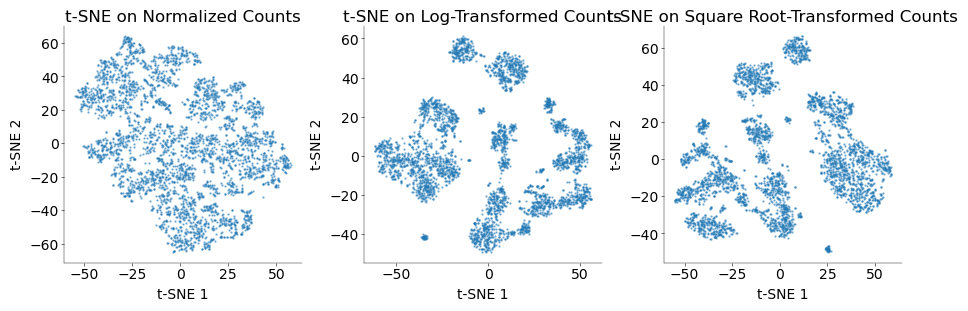

In [20]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
# t-SNE on normalized counts
axs[0].scatter(tsne_normal[:, 0], tsne_normal[:, 1], alpha=0.5, s=2)
axs[0].set_title("t-SNE on Normalized Counts")
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")

# t-SNE on log-transformed counts
axs[1].scatter(tsne_log[:, 0], tsne_log[:, 1], alpha=0.5, s=2)
axs[1].set_title("t-SNE on Log-Transformed Counts")
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")

# t-SNE on square root-transformed counts
axs[2].scatter(tsne_sqrt[:, 0], tsne_sqrt[:, 1], alpha=0.5, s=2)
axs[2].set_title("t-SNE on Square Root-Transformed Counts")
axs[2].set_xlabel("t-SNE 1")
axs[2].set_ylabel("t-SNE 2")

plt.show()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [23]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [27]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15

A = kneighbors_graph(
    pca_normal, n_neighbors=15, mode="connectivity", include_self=False
)

# Transform it into an igraph object

sources, targets = A.nonzero()

In [ ]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type
# Transform the adjacency matrix into an igraph object
sources, targets = A.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))
G = ig.Graph(edges)

# Run Leiden clustering on the graph
partition = la.find_partition(G, la.ModularityVertexPartition)

# Get cluster labels
cluster_labels = np.array(partition.membership)

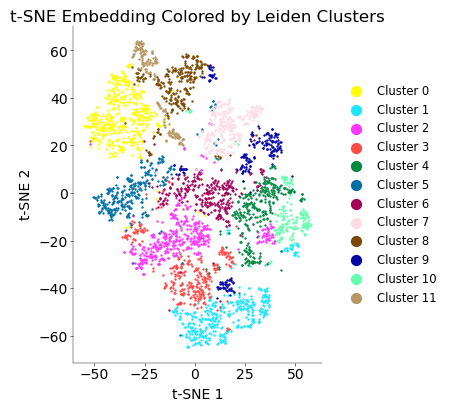

In [40]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))
for cluster in np.unique(cluster_labels):
    indices = cluster_labels == cluster
    ax.scatter(
        tsne_normal[indices, 0],
        tsne_normal[indices, 1],
        s=2,
        label=f"Cluster {cluster}",
        color=clusterCols[cluster % len(clusterCols)],
    )
ax.set_title("t-SNE Embedding Colored by Leiden Clusters")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.legend(loc="right", markerscale=10, bbox_to_anchor=(1.5, 0.5), fontsize="small")
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [ ]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------
# Define the resolution parameters
resolutions = [1.0, 0.5, 2.0]

# Dictionary to store cluster labels for each resolution
cluster_labels_dict = {}

# Run Leiden clustering with different resolutions
for resolution in resolutions:
    partition = la.find_partition(
        G, la.RBConfigurationVertexPartition, resolution_parameter=resolution
    )
    cluster_labels_dict[resolution] = np.array(partition.membership)

/var/folders/n5/j19jndm90jx7nmcl1rs908nm0000gn/T/ipykernel_33479/2820322183.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


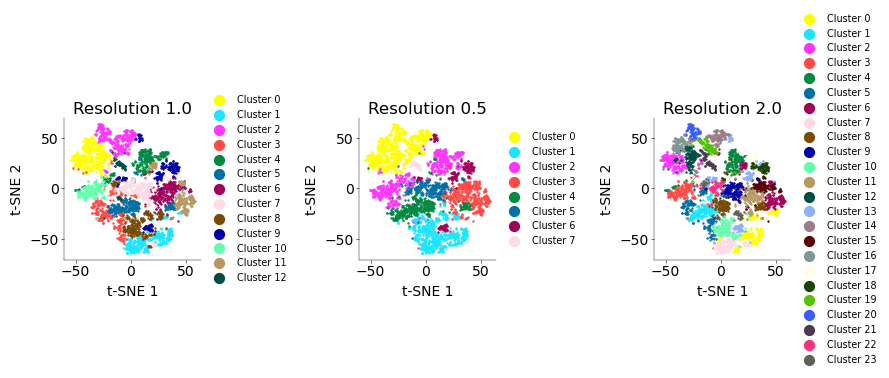

In [48]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for ax, resolution in zip(axs, resolutions):
    cluster_labels = cluster_labels_dict[resolution]
    for cluster in np.unique(cluster_labels):
        indices = cluster_labels == cluster
        ax.scatter(
            tsne_normal[indices, 0],
            tsne_normal[indices, 1],
            s=2,
            label=f"Cluster {cluster}",
            color=clusterCols[cluster % len(clusterCols)],
        )
    ax.set_title(f"Resolution {resolution}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10, fontsize="x-small"
    )

plt.tight_layout()
plt.show()